Ez a notebook a tanított machine learning modellek döntésének értelmezését és a felhasznált tulajdonságok összehasonlítását és valamilyen értlemeben mérését hivatott bemutatni.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

data_housing = pd.read_csv('./boston_housing.csv', index_col=0)

feature_names_housing = data_housing.keys().tolist()
feature_names_housing.remove('target')

X_housing = data_housing[feature_names_housing]
y_housing = data_housing.target

train_X_housing, val_X_housing, train_y_housing, val_y_housing = train_test_split(X_housing, y_housing, random_state=1)
forest_model_housing = RandomForestRegressor(n_estimators=30, random_state=1).fit(train_X_housing, train_y_housing)

In [2]:
print('Accuracy',forest_model_housing.score(val_X_housing, val_y_housing))

Accuracy 0.9099028894828541


Első módszer a permutation importance. A metódus lényege az, hogy a validáló adathalmazunkban egy oszlopot random összkeverünk és megnézzük, hogy az így kapott adatokon mekkora lesz a modell össz hibája. A hiba eltérésének a mértékéből lehet következtetni, hogy a modell mennyire támaszkodik erre a tulajdonságra.

In [3]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(forest_model_housing, random_state=1).fit(val_X_housing, val_y_housing)
eli5.show_weights(perm, feature_names=val_X_housing.columns.tolist())

Weight,Feature
0.8677 ± 0.1423,LSTAT
0.3743 ± 0.0739,RM
0.0353 ± 0.0212,DIS
0.0350 ± 0.0125,NOX
0.0295 ± 0.0051,CRIM
0.0251 ± 0.0113,PTRATIO
0.0144 ± 0.0059,TAX
0.0093 ± 0.0077,AGE
0.0086 ± 0.0065,B
0.0045 ± 0.0039,INDUS


Következő lehetőség a partial dependence plots. Ez azt mutatja meg, hogyha egy tulajdonságot változtatunk és a többit fix értéken tartjuk akkor a változó tulajdonság, hogy befojásolja a modell kimenetét. Az alábbiakban az LSTAT tulajdonságot változtatjuk és ennek a befolyása látszik a diagramon.

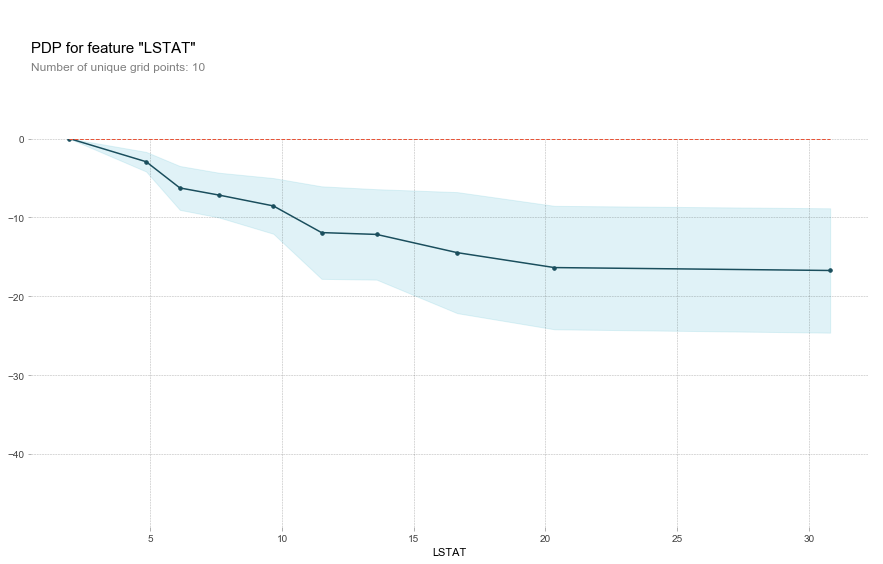

In [5]:
from matplotlib import pyplot as plt
from pdpbox import pdp

pdp_goals = pdp.pdp_isolate(model=forest_model_housing, dataset=val_X_housing, model_features=feature_names_housing, feature='LSTAT')
pdp.pdp_plot(pdp_goals, 'LSTAT')
plt.show()

Harmadik módszer a SHAP(SHapley Additive exPlanations) érték számítása. Ennek a célja egy predikció kimenetelét értelmezni. Kiszámoljuk a kimenetet arra a bemenetre ahol minden tulajdonság a saját átlagát veszi fel. Majd vizsgáljuk, hogy egy  tulajdonságot változtatunk az aktuális bemenet értékére, hogy változik ettől a kimenet. A kimenet változása lesz ehhez a tulajdonsághoz tartozó SHAP érték.

In [6]:
import shap

data_for_prediction = val_X_housing.iloc[0]
explainer = shap.TreeExplainer(forest_model_housing)
shap_value_for_prediction = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_value_for_prediction, data_for_prediction)


Több predikció SHAP értékeiből egy diagram készíthető amiből bizonyos tulajdonságok befolysása szűrhető le. A diagram magyarázata:a szín azt jelenti, hogy az áltag alatt vagy felett. Így átfogó képet kaphatunk arról, hogy a különböző tulajdonságok, hogy befolyásolják a kimenetet.

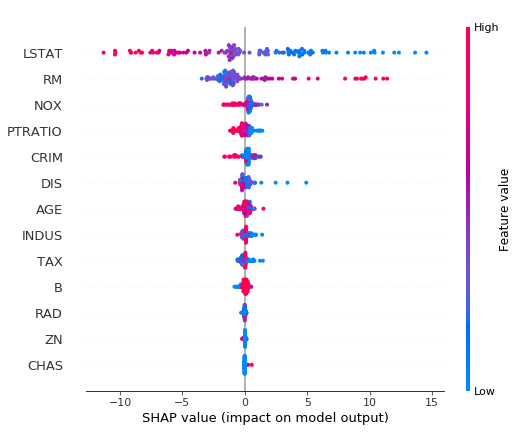

In [7]:
shap_values = explainer.shap_values(val_X_housing)
shap.summary_plot(shap_values, val_X_housing)

A fent tárgyalt metódusok más adathalmazra ábrázolva.

In [8]:

from sklearn.ensemble import RandomForestClassifier

data_chrun = pd.read_csv('churn.txt', sep=",")
data_chrun = data_chrun.rename(columns={'Churn?': 'Churn'})

del data_chrun['Phone']
state_onehots = pd.get_dummies(data_chrun['State'], prefix='State')
del data_chrun['State']
data_chrun = pd.concat([data_chrun, state_onehots], axis=1)

feature_names_churn = data_chrun.keys().tolist()
feature_names_churn.remove('Churn')

X_churn = data_chrun[feature_names_churn]
X_churn["Int'l Plan"] = (X_churn["Int'l Plan"] == "yes")
X_churn['VMail Plan'] = (X_churn['VMail Plan'] == "yes")

y_churn = (data_chrun.Churn == "True.")

train_X_churn, val_X_churn, train_y_churn, val_y_churn = train_test_split(X_churn, y_churn, random_state=1)
forest_model_churn = RandomForestClassifier(n_estimators=30, random_state=1).fit(train_X_churn, train_y_churn)


In [9]:
from sklearn.metrics import accuracy_score
validation_output = forest_model_churn.predict(val_X_churn)
print('Accuracy', accuracy_score(validation_output, val_y_churn))

Accuracy 0.934052757793765


In [10]:
perm_churn = PermutationImportance(forest_model_churn, random_state=1).fit(val_X_churn, val_y_churn)
eli5.show_weights(perm_churn, feature_names=val_X_churn.columns.tolist())

Weight,Feature
0.0573 ± 0.0101,Day Mins
0.0424 ± 0.0112,Int'l Plan
0.0348 ± 0.0103,CustServ Calls
0.0204 ± 0.0102,Day Charge
0.0189 ± 0.0063,Intl Calls
0.0149 ± 0.0087,Intl Mins
0.0141 ± 0.0067,Eve Mins
0.0122 ± 0.0093,Eve Charge
0.0115 ± 0.0049,Intl Charge
0.0086 ± 0.0088,VMail Message


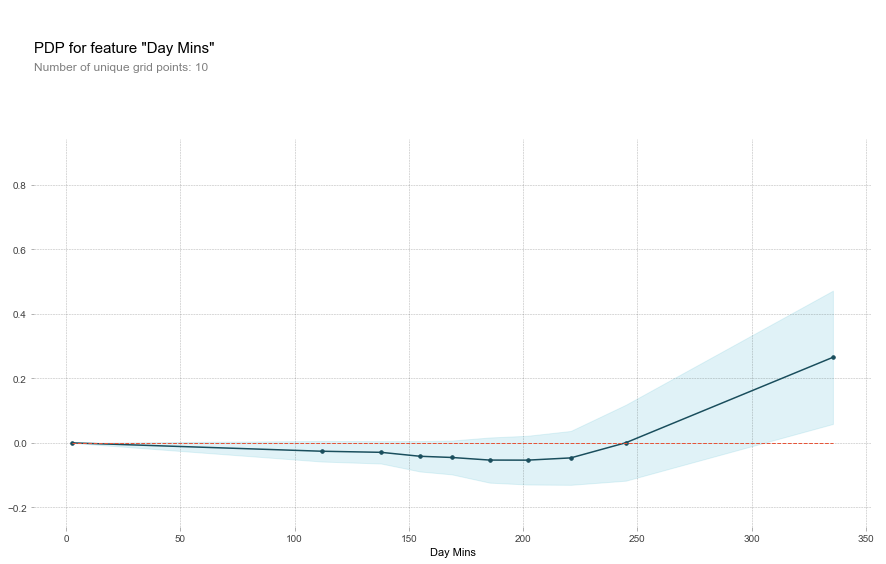

In [11]:
pdp_goals = pdp.pdp_isolate(model=forest_model_churn, dataset=val_X_churn, model_features=feature_names_churn, feature='Day Mins')
pdp.pdp_plot(pdp_goals, 'Day Mins')
plt.show()

In [12]:
data_for_prediction_churn = val_X_churn.iloc[0]
explainer_churn = shap.TreeExplainer(forest_model_churn)
shap_value = explainer_churn.shap_values(data_for_prediction_churn)
shap.initjs()
shap.force_plot(explainer_churn.expected_value[0], shap_value[0], data_for_prediction_churn)


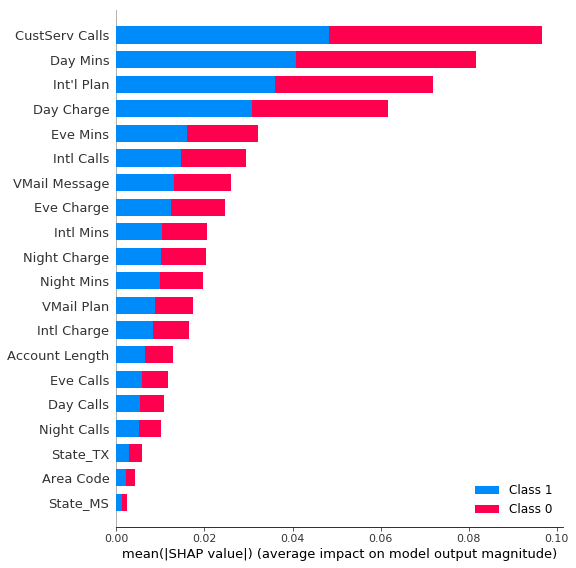

In [76]:
shap_values = explainer_churn.shap_values(val_X_churn)
shap.summary_plot(shap_values, val_X_churn)